# Linear Combination of scattering distributions

This example shows how to use linear-combinations to define the scattering distributions.

In [9]:
# imports
from rt1.rt1 import RT1

from rt1.volume import HenyeyGreenstein
from rt1.volume import LinCombV

from rt1.surface import CosineLobe
from rt1.surface import Isotropic
from rt1.surface import LinCombSRF

import numpy as np
import pandas as pd

**Definition of linear-combination for volume-scattering phase-functions**

In [3]:
# list of volume-scattering phase-functions to be combined
phasechoices = [HenyeyGreenstein(t=  0.5, ncoefs = 10, a=[-1., 1., 1.]),  # forward-scattering-peak
                HenyeyGreenstein(t= -0.2, ncoefs = 10, a=[-1., 1., 1.]),  # backscattering-peak
                HenyeyGreenstein(t= -0.5, ncoefs = 10, a=[ 1., 1., 1.]),  # downward-specular peak
                HenyeyGreenstein(t=  0.2, ncoefs = 10, a=[ 1., 1., 1.]),  # upward-specular peak
               ]

# list of weighting-factors for the individual phase-functions
Vweights = [.3,.3,.2,.2]

# generate correctly shaped arrays of the phase-functions and their corresponding weighting-factors:
Vchoices = [[Vweights[i], phasechoices[i]] for i in range(len(phasechoices))]

# generate combined volume-class element
V = LinCombV(tau=0.5, omega=0.4, Vchoices=Vchoices)

**Definition of linear-combination for BRDF's**

In [4]:
# list of surface-BRDF-functions to be combined
BRDFchoices = [CosineLobe(ncoefs=10, i=12, a=[0.8, 1., 1.]),        # specular peak with a_0 = 0.8
               Isotropic(),                                         # isotropic scattering contribution
              ]

# list of weighting-factors for the individual BRDF's
BRDFweights = [0.25, 0.1]

# generate correctly shaped arrays of the phase-functions and their corresponding weighting-factors:
SRFchoices = [[BRDFweights[i], BRDFchoices[i]] for i in range(len(BRDFchoices))]

# generate combined surface-class element
SRF = LinCombSRF(SRFchoices=SRFchoices, NormBRDF=1.)

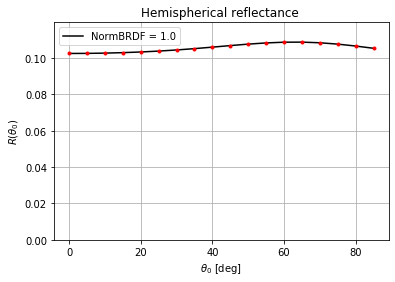

In [5]:
# evaluate and plot the hemispherical reflectance that is associated with the generated BRDF:
plot_refl = SRF.hemreflect()

 **!!!   The cells below are identical to example01 and example02 !!!**

**Imaging geometry (backscattering case)**

In [6]:
# Specify imaging geometry
inc = np.arange(1.,89.,1.)  # specify incidence angle range [deg]
t_0 = np.deg2rad(inc)  # [rad]
# scattering angle; here the same as incidence angle, as backscatter
t_ex = t_0*1. 
# azimuth geometry angles
p_0 = np.ones_like(inc)*0. 
p_ex = np.ones_like(inc)*0. + np.pi  # 180 degree shift as backscatter

**Perform the simulations**

To perform the simulations, the RT model needs to estimate once coefficients. As these are the same for all imaging geometries, it makes sense to estimate these once and then transfer them to the subsequent calls.

In [10]:
# do actual calculations with specifies geometries
I0=1.  # set incident intensity
R = RT1(I0, t_0, t_ex, p_0, p_ex, V=V, SRF=SRF, geometry='mono')
res = pd.DataFrame(dict(zip(('tot','surf','vol','inter'), R.calc())), index=inc)

generation of _fnevals functions...
symengine
evaluating fn-coefficients...


**Plot results**

Plot both, the phase function and the BRDF. For more examples, see [examples.py](examples.py)

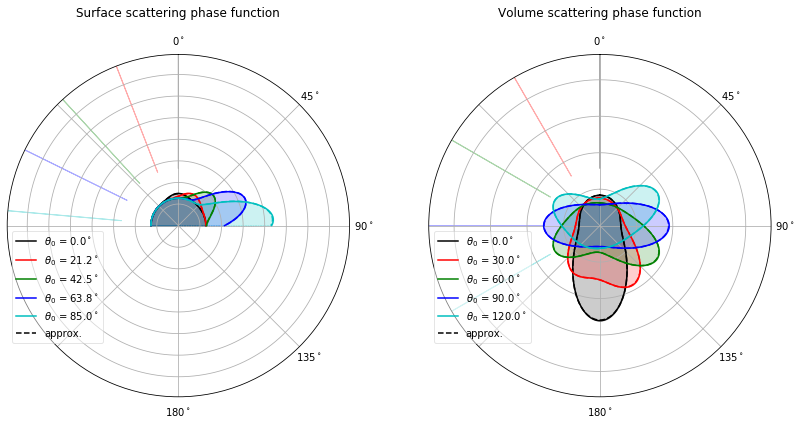

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(25, 7))
ax1 = fig.add_subplot(111, projection='polar')
ax2 = fig.add_subplot(121, projection='polar')

# plot BRDF and phase function
plot1 = SRF.polarplot(inc = list(np.linspace(0,85,5)), multip = 1.5, legpos = (0.,0.5), polarax=ax2,
                     label='Surface scattering phase function', legend=True)
plot2 = V.polarplot(inc = list(np.linspace(0,120,5)) ,multip = 1.5, legpos = (0.0,0.5), polarax=ax1,
                     label='Volume scattering phase function', legend=True)

fig.tight_layout()
# plot only BRDF
#V.polarplot()
#plot only p
#SRF.polarplot()

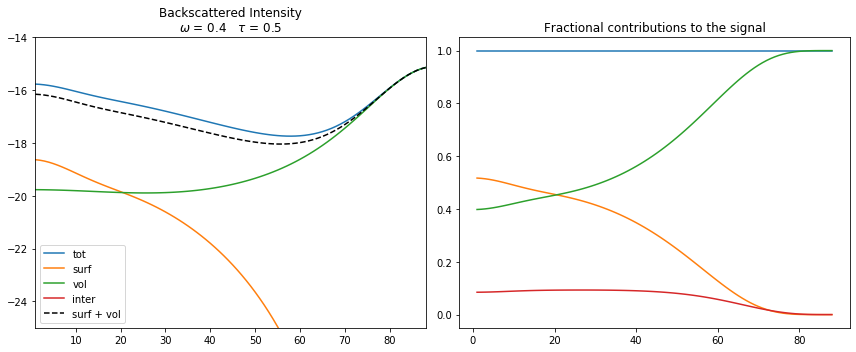

In [21]:
# plot backscatter as function of incidence angle

f, [ax, ax2] = plt.subplots(1,2, figsize=(12,5))
ax.set_title('Backscattered Intensity'+'\n$\\omega$ = ' + str(R.V.omega) + '$ \quad \\tau$ = ' + str(R.V.tau))
ax2.set_title('Fractional contributions to the signal')

resdb = 10.*np.log10(res[res!=0])
resdb.plot(ax=ax)

ax.plot(10.*np.log10(res[['surf','vol']].sum(axis=1)), c='k', ls='--', label='surf + vol')

ax.legend()
ax2.plot(res.div(res.tot, axis=0))

_ = ax.set_ylim(-25,-14)
ax.set_ylim()
f.tight_layout()